<a href="https://colab.research.google.com/github/MAI3003-Data-Witches/AtrialFibrillation-detection/blob/challenge/DataWitches_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Witches**

| **Name**         | **Student ID** |
|------------------|----------------|
| Claessen, VVHJAE | i6339543       |
| Ovsiannikova, AM | i6365923       |
| Pubben, J        | i6276134       |
| Roca Cugat, M    | i6351071       |
| Záboj, J         | i6337952       |

# **Logbook**

## Methods

Let's ensure we all use the same names for all components.

| **Variable**                 | **Name**                                      |
|------------------------------|-----------------------------------------------|
| Raw ECG dataframe            | df                                            |
| Label dataframe              | df_labels                                     |
| HRV features (train)         | hrv_train                                     |
| HRV features (test)          | hrv_test                                      |
| HRV extraction type          | FULL (nk.hrv — time + freq + nonlinear + RSA) |
| Clean HRV dataframe (train)  | hrv_train_clean                               |
| Clean HRV dataframe (test)   | hrv_test_clean                                |
| HRV + labels (train)         | hrv_train_with_labels                         |
| Winsorized HRV column        | HRV_MedianNN_winsor                           |
| Model feature matrix (train) | X_train                                       |
| Model feature matrix (test)  | X_test                                        |
| Model target vector (train)  | y_train                                       |
| Model target vector (test)   | y_test                                        |


| **Function**              | **Description**                                | **Arguments**                                |
|---------------------------|------------------------------------------------|----------------------------------------------|
| corr_plot_hrv()           | Correlation plot for HRV features              | df, cols=None                                |
| distplots_hrv()           | Distribution plots (hist + KDE)                | df, cols=None                                |
| boxplots_hrv()            | Boxplots for selected HRV variables            | df, cols                                     |
| check_missing_hrv()       | Missingness summary                            | df                                           |
| identify_outliers()       | IQR-based outlier detection                    | df, column_name, threshold=1.5               |
| model_evaluation()        | Confusion matrix + classification report       | model                                        |
| model_desc()              | Accuracy, CV, ROC-AUC, model performance       | model                                        |


# Preface

## Packages imports

In [123]:
try:
    print("Loading required packages...")
    import sys
    import random
    import os.path
    import warnings
    from tqdm import tqdm

    import numpy as np
    import pandas as pd
    import seaborn as sns
    import neurokit2 as nk
    from scipy import stats
    import scipy.signal as signal
    from scipy.signal import welch
    import matplotlib.pyplot as plt
    from joblib.testing import xfail
    import plotly.graph_objects as go
    from colorama import Fore, Back, Style
    from plotly.subplots import make_subplots

    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.compose import make_column_transformer
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

    from sklearn.neural_network import MLPClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
    from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

    from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
        f1_score, precision_score, recall_score, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve
    from sympy import false

    print("Loading successful!")
except Exception:
    print("Installing required packages...")
    !pip install -r https://raw.githubusercontent.com/MAI3003-Data-Witches/AtrialFibrillation-detection/refs/heads/challenge/requirements.txt

    print("Loading required packages...")
    import sys
    import random
    import os.path
    import warnings
    from tqdm import tqdm

    import numpy as np
    import pandas as pd
    import seaborn as sns
    import neurokit2 as nk
    from scipy import stats
    import scipy.signal as signal
    from scipy.signal import welch
    import matplotlib.pyplot as plt
    from joblib.testing import xfail
    import plotly.graph_objects as go
    from colorama import Fore, Back, Style
    from plotly.subplots import make_subplots

    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.compose import make_column_transformer
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

    from sklearn.neural_network import MLPClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

    from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
        f1_score, precision_score, recall_score, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve
    from sympy import false

    print("Loading successful!")

Loading required packages...
Loading successful!


## Options settings

In [124]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
random.seed(3003)
IN_COLAB = 'google.colab' in sys.modules
DATA_PRESENT = os.path.isfile("data/Physionet2017Training.tar.xz")
LoadPremadeDataset = False

## Dataset download

In [125]:
dataset_location = 'data/Physionet2017TrainingData.csv'

In [126]:
if not DATA_PRESENT:
    !mkdir data
    !wget https://github.com/MAI3003-Data-Witches/Data-Witches_Project2/raw/refs/heads/main/data/Physionet2017Training.tar.xz -O data/Physionet2017Training.tar.xz
    !tar -xf data/Physionet2017Training.tar.xz -C data
else:
    print(f"You already have the dataset downloaded at {dataset_location}, skipping")

You already have the dataset downloaded at data/Physionet2017TrainingData.csv, skipping


In [127]:
df = pd.read_csv(dataset_location, header=None, index_col=False) * 1000  # Load the dataset already in mV

df.head()

0       1       2       3       4       5       6       7       8     \
0 -126000 -141000 -152000 -159000 -160000 -153000 -140000 -126000 -111000   
1   23000   25000   33000   61000   79000   85000   89000   93000   96000   
2 -116000 -146000 -174000 -190000 -199000 -207000 -211000 -211000 -207000   
3 -500000 -597000 -695000 -792000 -873000 -917000 -918000 -873000 -822000   
4  -74000  -96000 -118000 -141000 -153000 -162000 -169000 -174000 -177000   

     9       10      11      12      13      14      15      16      17    \
0  -93000  -72000  -46000  -17000       0   22000   55000   94000  123000   
1   98000   98000   99000  100000  100000  101000  101000  102000  102000   
2 -201000 -194000 -190000 -187000 -184000 -180000 -176000 -172000 -169000   
3 -767000 -751000 -740000 -730000 -722000 -715000 -709000 -703000 -698000   
4 -179000 -180000 -180000 -179000 -175000 -171000 -165000 -159000 -152000   

     18      19      20      21      22      23      24      25      26    \
0  145000  163000  169000  171000  171000  172000  172000  173000  174000   
1  102000  101000  102000  102000  103000  103000  103000  104000  106000   
2 -168000 -167000 -167000 -167000 -167000 -169000 -170000 -173000 -175000   
3 -695000 -693000 -691000 -690000 -689000 -687000 -685000 -683000 -682000   
4 -142000 -123000 -104000  -96000  -92000  -89000  -86000  -84000  -82000   

     27      28      29      30      31      32      33      34      35    \
0  173000  172000  172000  172000  171000  170000  169000  169000  170000   
1  108000  110000  111000  113000  115000  117000  118000  120000  121000   
2 -177000 -178000 -180000 -182000 -184000 -186000 -188000 -190000 -192000   
3 -681000 -680000 -680000 -681000 -684000 -688000 -695000 -701000 -706000   
4  -81000  -80000  -80000  -79000  -77000  -75000  -75000  -74000  -73000   

     36      37      38      39      40      41      42      43      44    \
0  169000  169000  171000  173000  176000  178000  181000  185000  191000   
1  124000  127000  131000  135000  139000  144000  147000  151000  155000   
2 -194000 -196000 -197000 -199000 -199000 -199000 -198000 -197000 -194000   
3 -713000 -720000 -727000 -733000 -737000 -740000 -743000 -747000 -753000   
4  -73000  -72000  -71000  -70000  -70000  -69000  -69000  -68000  -67000   

     45      46      47      48      49      50      51      52      53    \
0  203000  214000  227000  249000  277000  296000  312000  335000  367000   
1  160000  166000  173000  186000  199000  213000  229000  248000  267000   
2 -191000 -187000 -183000 -179000 -175000 -171000 -167000 -163000 -158000   
3 -762000 -768000 -772000 -774000 -776000 -778000 -780000 -777000 -769000   
4  -65000  -64000  -62000  -61000  -60000  -59000  -59000  -60000  -61000   

     54      55      56      57      58      59      60      61      62    \
0  402000  426000  444000  470000  494000  514000  528000  536000  543000   
1  276000  280000  284000  286000  288000  290000  292000  295000  297000   
2 -153000 -148000 -144000 -139000 -135000 -131000 -127000 -124000 -122000   
3 -758000 -746000 -731000 -722000 -715000 -710000 -706000 -703000 -701000   
4  -63000  -65000  -68000  -71000  -74000  -76000  -79000  -80000  -82000   

     63      64      65      66      67      68      69      70      71    \
0  549000  554000  556000  557000  555000  550000  544000  537000  531000   
1  300000  302000  305000  307000  311000  314000  318000  323000  334000   
2 -120000 -119000 -118000 -117000 -115000 -113000 -112000 -111000 -110000   
3 -699000 -697000 -693000 -689000 -684000 -680000 -677000 -674000 -670000   
4  -84000  -86000  -89000  -90000  -89000  -86000  -80000  -73000  -64000   

     72      73      74      75      76      77      78      79      80    \
0  528000  525000  521000  516000  512000  509000  505000  502000  498000   
1  345000  356000  361000  364000  367000  370000  373000  375000  376000   
2 -110000 -109000 -108000 -107000 -106000 -105000 -104000 -102000 -101

# Data preprocessing
## Extract ECG signals and class labels

In [128]:
df_labels = pd.read_csv('data/Physionet2017TrainingLabels.csv', header=None, names=['label'])
df_labels['classification'] = df_labels['label'].replace({"N": 0, "A": 1})
df_labels['label'] = df_labels['label'].replace({"N": 'Normal Sinus Rhythm', "A": 'Atrial Fibrillation'})

In [129]:
df_labels

,label,classification
0,Normal Sinus Rhythm,0
1,Normal Sinus Rhythm,0
2,Normal Sinus Rhythm,0
3,Normal Sinus Rhythm,0
4,Normal Sinus Rhythm,0
...,...,...
4519,Normal Sinus Rhythm,0
4520,Normal Sinus Rhythm,0
4521,Atrial Fibrillation,1
4522,Normal Sinus Rhythm,0


## Dataset splitting

In [130]:
df_labeled = pd.merge(df_labels.drop(columns='label'), df, left_on='classification', right_index=True)

train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df_labels["label"],
    random_state=3003
)

print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

Train size: 3619
Test size: 905


# Exploratory Data Analysis
## Dataset characteristics

In [131]:
num_ecgs = len(df)  # Number of ECGs

num_samples = df.shape[1]  # Number of samples per ECG

sampling_frequency = 300  #Hz
duration = num_samples / sampling_frequency  # Duration of each ECG

class_distribution = df_labels['label'].value_counts()  # Distribution over classes

print(f"Number of ECGs: {num_ecgs}")
print(f"Number of samples per ECG: {num_samples}")
print(f"Duration of each ECG: {duration} seconds")
print(f"\nClass Distribution:\n{class_distribution}")

Number of ECGs: 4524
Number of samples per ECG: 9000
Duration of each ECG: 30.0 seconds

Class Distribution:
label
Normal Sinus Rhythm    3950
Atrial Fibrillation     574
Name: count, dtype: int64


In [132]:
# Indices per class (based on df_labels)
sinus_indices = df_labels[df_labels["label"] == "Normal Sinus Rhythm"].index.tolist()
af_indices = df_labels[df_labels["label"] == "Atrial Fibrillation"].index.tolist()

example_sinus_idx = random.choice(sinus_indices)
example_af_idx = random.choice(af_indices)

ecg_sinus_raw = df.iloc[example_sinus_idx].astype(float).values
ecg_af_raw = df.iloc[example_af_idx].astype(float).values

time = np.arange(0, len(ecg_sinus_raw)) / sampling_frequency

In [133]:
# Summary statistics for each ECG
summary_stats = df.describe().T
summary_stats = pd.concat([summary_stats, df_labels], axis=1)

# Feature extraction

## ECG feature engineering

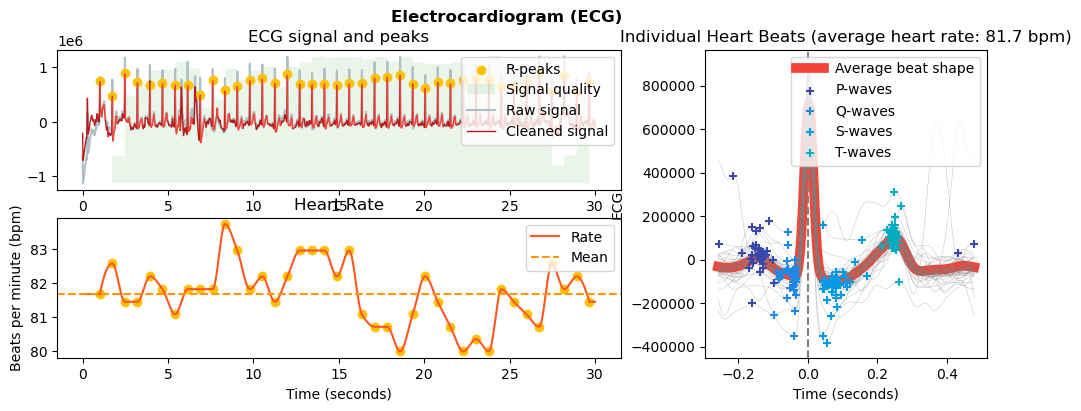

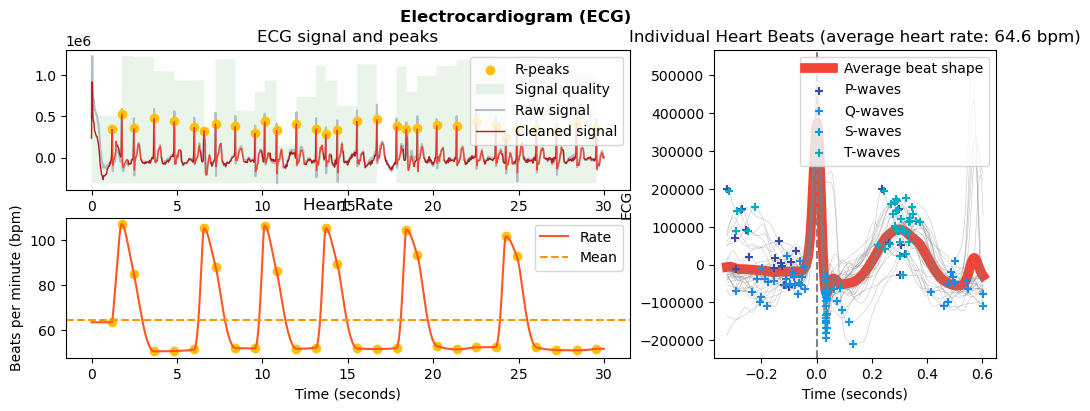

In [134]:
# Select an ECG in Normal Sinus Rhythm and one in AF and process them
selected_sinus_indices = random.sample(sinus_indices, 1)
selected_af_indices = random.sample(af_indices, 1)

ecg_NSR = df.iloc[selected_sinus_indices[0]].astype(float)
signals_NSR, info_NSR = nk.ecg_process(ecg_NSR, sampling_rate=sampling_frequency)

plt.rcParams['figure.figsize'] = [12, 4]
nk.ecg_plot(signals_NSR, info_NSR)

ecg_AF = df.iloc[selected_af_indices[0]].astype(float)
signals_AF, info_AF = nk.ecg_process(ecg_AF, sampling_rate=sampling_frequency)

nk.ecg_plot(signals_AF, info_AF)

#### R-peaks**

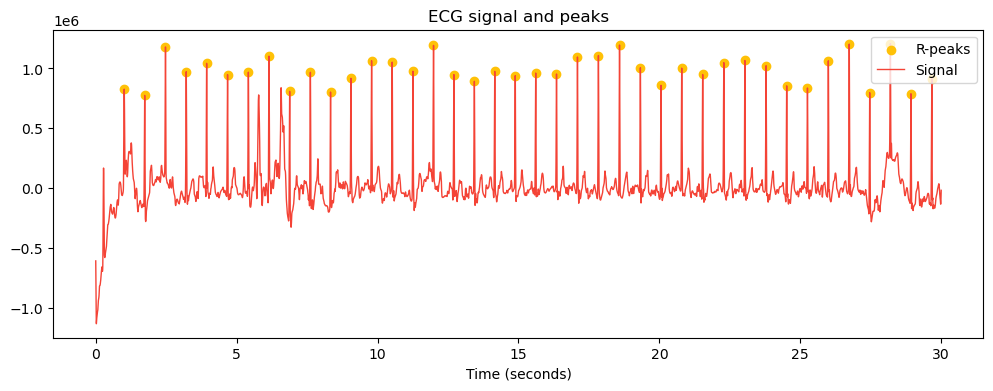

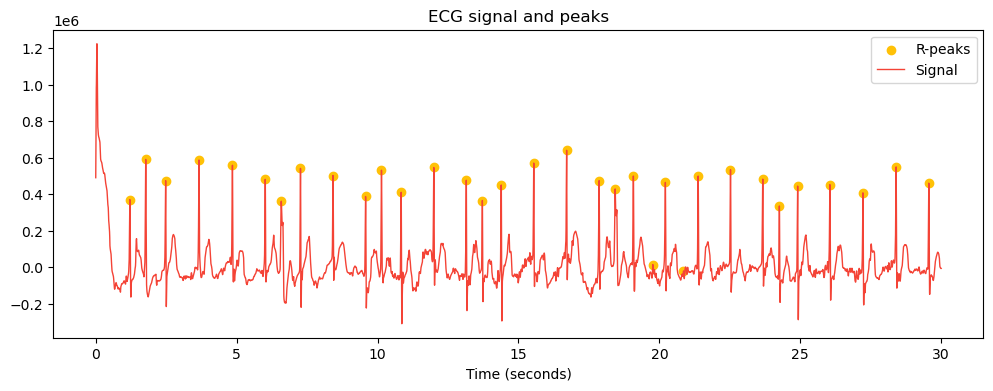

In [135]:
# Find R-peaks
peaks_NSR, info_NSR = nk.ecg_peaks(ecg_NSR, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)
peaks_AF, info_AF = nk.ecg_peaks(ecg_AF, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)

#### Time-domain features

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,734.615385,8.467875,NaN,NaN,NaN,NaN,NaN,NaN,8.532703,8.643127,0.011527,0.011615,733.333333,9.884,0.013478,11.666667,0.992402,726.666667,743.333333,0.0,0.0,716.666667,753.333333,2.4375,31.25


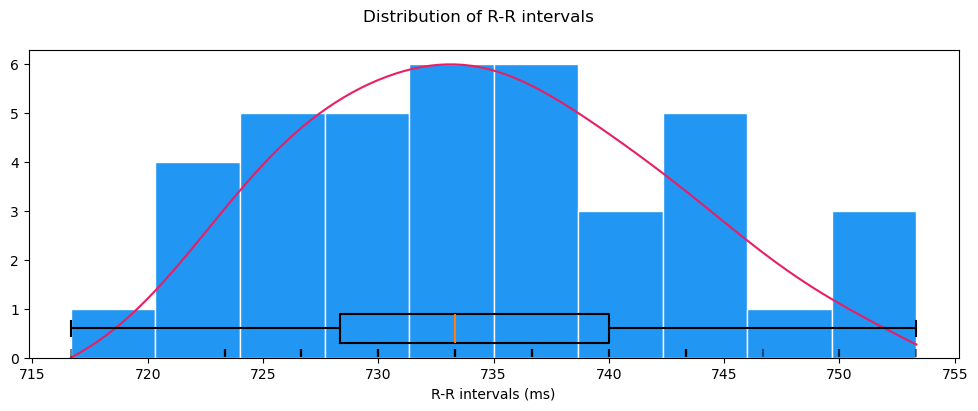

In [136]:
# Time domain features NSR
hrv_time_NSR = nk.hrv_time(peaks_NSR, sampling_rate=sampling_frequency, show=True)
hrv_time_NSR

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,885.833333,284.324011,NaN,NaN,NaN,NaN,NaN,NaN,332.529676,337.459693,0.320968,0.375386,923.333333,365.708,0.396074,525.0,0.855033,573.333333,1159.333333,62.5,71.875,440.0,1186.666667,6.4,125.0


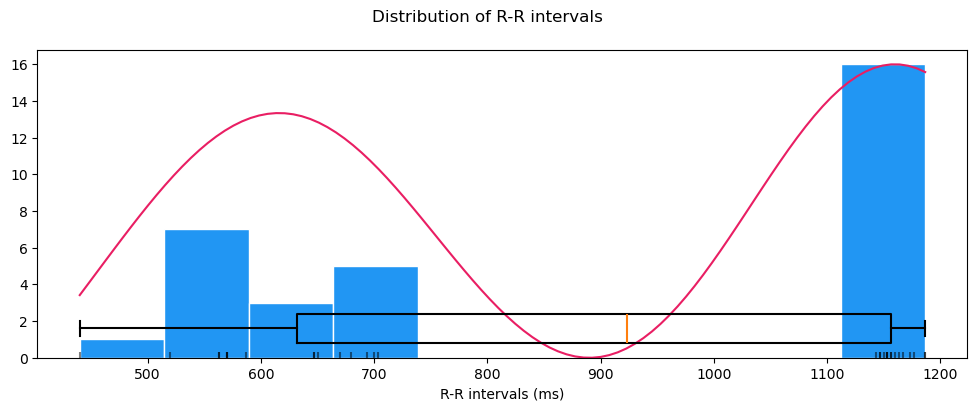

In [137]:
# Time domain features AF
hrv_time_AF = nk.hrv_time(peaks_AF, sampling_rate=sampling_frequency, show=True)
hrv_time_AF

### FULL HRV feature extraction for all ECGs (TRAIN)

In [138]:
#Getting all the ECG readouts so we can extract P-wave information

def get_ECG_readout_train():
    test_run = 0
    ecg_full = pd.DataFrame()  # Initialize an empty DataFrame

    for i in tqdm(train_idx):

        ecg = df.iloc[i].astype(float)
        signals, info = nk.ecg_process(ecg, sampling_rate=sampling_frequency)

        # Assign the current ecg_index to the signals DataFrame before concatenation
        signals["ecg_index"] = i

        ecg_full = pd.concat([ecg_full, signals], ignore_index=True)

        #test_run += 1

        if test_run == 10:
            break  # Stop after 10 iterations for the example

    return ecg_full

In [139]:
if LoadPremadeDataset == False:
  ecg_full = get_ECG_readout_train()

 11%|████████▊                                                                      | 404/3619 [01:23<13:42,  3.91it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x7ff9a3f9ae80>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
 11%|████████▊                                                                      | 405/3619 [01:23<14:15,  3.76it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x7fe3bb09ae80>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.

In [140]:
def get_ECG_metrics(ecg_full):
    ecg_metrics_list = []

    for i in tqdm(train_idx[:]):
        mean_quality = ecg_full.loc[ecg_full.ecg_index == i]['ECG_Quality'].mean()
        mean_pwave_amplitude = ecg_full.loc[(ecg_full.ecg_index == i) & (ecg_full['ECG_P_Peaks'] == 1)][
            'ECG_Clean'].mean()  #You could consider taking sqrt, mean and then **2
        #(more robust) to outliers
        stdev_pwave = ecg_full.loc[(ecg_full.ecg_index == i) & (ecg_full['ECG_P_Peaks'] == 1)]['ECG_Quality'].std()
        #Perhaps I could add something about irregularly irregular rhythm, but it's (really) difficult mathematically
        ecg_metrics_list.append({
            'Mean_Quality': mean_quality,
            'Mean_PWave_Amplitude': mean_pwave_amplitude,
            'STDEV_Pwave': stdev_pwave,
            'ecg_index': i
        })

    return pd.DataFrame(ecg_metrics_list)

In [141]:
if LoadPremadeDataset == False:
  ecg_metrics = get_ECG_metrics(ecg_full)

100%|██████████████████████████████████████████████████████████████████████████████| 3619/3619 [05:07<00:00, 11.77it/s]


In [142]:
if LoadPremadeDataset == False:
    #FULL HRV feature extraction for all ECGs (TRAIN)

    hrv_features_train = []

    for i in tqdm(train_idx, desc="HRV (ALL FEATURES): TRAIN SET"):
        # Grab raw ECG
        ecg = df.iloc[i].astype(float).values

        try:
            # 1. Clean ECG
            ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

            # 2. Detect R-peaks
            peaks, _ = nk.ecg_peaks(
                ecg_clean,
                sampling_rate=sampling_frequency,
                correct_artifacts=True
            )

            # 3. Compute FULL HRV feature set
            hrv_full = nk.hrv(
                peaks,
                sampling_rate=sampling_frequency,
                show=False
            )

            # Ensure row is a proper 1-row DataFrame and add ecg_index
            hrv_full = hrv_full.copy()
            hrv_full["ecg_index"] = i

            hrv_features_train.append(hrv_full)

        except Exception as e:
            print(f"Error processing TRAIN ECG {i}: {e}")

            if hrv_features_train:
                empty = pd.DataFrame(
                    [np.nan] * hrv_features_train[0].shape[1],
                    index=hrv_features_train[0].columns
                ).T
                empty["ecg_index"] = i
                hrv_features_train.append(empty)

    # Combine to single DataFrame
    hrv_train = pd.concat(hrv_features_train, ignore_index=True)

    print("hrv_train shape:", hrv_train.shape)
    hrv_train.head()

HRV (ALL FEATURES): TRAIN SET: 100%|███████████████████████████████████████████████| 3619/3619 [01:01<00:00, 59.11it/s]


hrv_train shape: (3619, 84)


In [143]:
if LoadPremadeDataset == False:
    # Merge our new dataframe with our extra variables
    hrv_train = pd.merge(hrv_train, ecg_metrics, on='ecg_index', how='left')
    hrv_train.head()

In [144]:
if LoadPremadeDataset == False:
    # Remove all columns from the dataframe that contain more than 50% NaN
    threshold = 0.5
    hrv_train_clean = hrv_train.dropna(thresh=len(hrv_train) * threshold, axis=1)

    # Remove all rows that are all NaN
    hrv_train_clean = hrv_train_clean.dropna(how='all')

    hrv_train_clean.to_csv("data/hrv_train.csv", index=False)
    hrv_train_clean.head()

### FULL HRV feature extraction for all ECGs (TEST)

In [145]:
#Getting all the ECG readouts so we can extract P-wave information

def get_ECG_readout_test():
    test_run = 0
    ecg_full = pd.DataFrame()  # Initialize an empty DataFrame

    for i in tqdm(test_idx):

        ecg = df.iloc[i].astype(float)
        signals, info = nk.ecg_process(ecg, sampling_rate=sampling_frequency)

        # Assign the current ecg_index to the signals DataFrame before concatenation
        signals["ecg_index"] = i

        ecg_full = pd.concat([ecg_full, signals], ignore_index=True)

        #test_run += 1

        if test_run == 10:
            break  # Stop after 10 iterations for the example

    return ecg_full

In [146]:
if LoadPremadeDataset == False:
  ecg_full_test = get_ECG_readout_test()

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [03:20<00:00,  4.52it/s]


In [147]:
def get_ECG_metrics(ecg_full):
    ecg_metrics_list = []

    for i in tqdm(test_idx[:]):
        #mean_quality = ecg_full.loc[ecg_full.ecg_index == i]['ECG_Quality'].mean()
        #Note:ecg quality is only to make the training data less noisy
        mean_pwave_amplitude = ecg_full.loc[(ecg_full.ecg_index == i) & (ecg_full['ECG_P_Peaks'] == 1)][
            'ECG_Clean'].mean()  #You could consider taking sqrt, mean and then **2
        #(more robust) to outliers
        stdev_pwave = ecg_full.loc[(ecg_full.ecg_index == i) & (ecg_full['ECG_P_Peaks'] == 1)]['ECG_Quality'].std()
        #Perhaps I could add something about irregularly irregular rhythm, but it's (really) difficult mathematically
        ecg_metrics_list.append({
            'Mean_PWave_Amplitude': mean_pwave_amplitude,
            'STDEV_Pwave': stdev_pwave,
            'ecg_index': i
        })

    return pd.DataFrame(ecg_metrics_list)

In [148]:
if LoadPremadeDataset == False:
  ecg_metrics_test = get_ECG_metrics(ecg_full_test)

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [00:16<00:00, 54.24it/s]


In [149]:
if LoadPremadeDataset == False:
    hrv_features_test = []

    for i in tqdm(test_idx, desc="HRV (ALL FEATURES): TEST SET"):
        ecg = df.iloc[i].astype(float).values

        try:
            # 1. Clean ECG
            ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

            # 2. Detect R-peaks
            peaks, _ = nk.ecg_peaks(
                ecg_clean,
                sampling_rate=sampling_frequency,
                correct_artifacts=True
            )

            # 3. Compute FULL HRV feature set
            hrv_full = nk.hrv(
                peaks,
                sampling_rate=sampling_frequency,
                show=False
            )

            # Same as TRAIN: keep as 1-row DataFrame, add index
            hrv_full = hrv_full.copy()
            hrv_full["ecg_index"] = i

            hrv_features_test.append(hrv_full)

        except Exception as e:
            print(f"Error processing TEST ECG {i}: {e}")

            if hrv_features_test:
                empty = pd.DataFrame(
                    [np.nan] * hrv_features_test[0].shape[1],
                    index=hrv_features_test[0].columns
                ).T
                empty["ecg_index"] = i
                hrv_features_test.append(empty)

    hrv_test = pd.concat(hrv_features_test, ignore_index=True)

    print("hrv_test shape:", hrv_test.shape)
    hrv_test.head()

HRV (ALL FEATURES): TEST SET: 100%|██████████████████████████████████████████████████| 905/905 [00:14<00:00, 61.89it/s]


hrv_test shape: (905, 84)


In [150]:
if LoadPremadeDataset == False:
    # Merge our new dataframe with our extra variables
    hrv_test = pd.merge(hrv_test, ecg_metrics_test, on='ecg_index', how='left')
    hrv_test.head()

In [151]:
if LoadPremadeDataset == False:
    # Remove all columns from the dataframe that contain more than 50% NaN
    threshold = 0.5
    hrv_test_clean = hrv_test.dropna(thresh=len(hrv_test) * threshold, axis=1)

    # Remove all rows that are all NaN
    hrv_test_clean = hrv_test_clean.dropna(how='all')

    hrv_test_clean.head()

    hrv_test.to_csv("data/hrv_test.csv", index=False)

# If you don't want to wait that long

In [152]:
if LoadPremadeDataset == True:
    hrv_test_clean = pd.read_csv("data/hrv_test.csv")
    hrv_train_clean= pd.read_csv("data/hrv_train.csv")

### Feature exploration

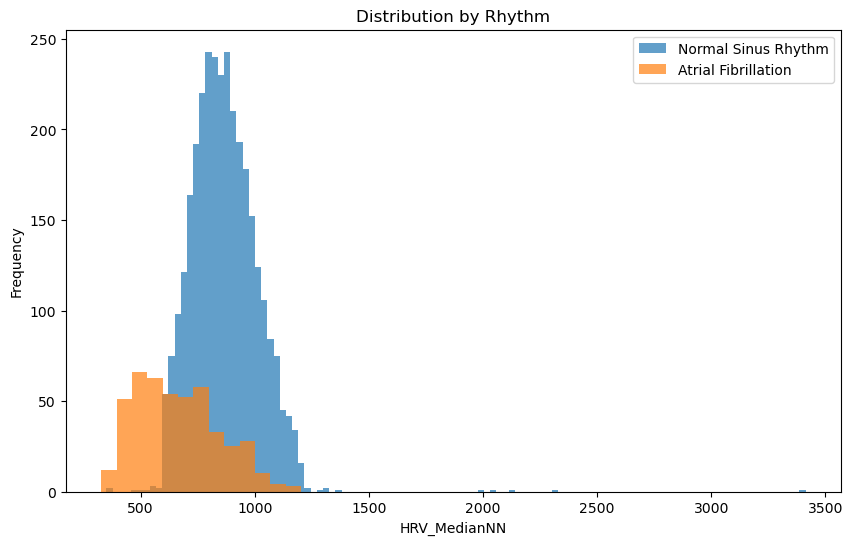

In [153]:
# Merge the HRV data with the rhythm labels
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on='ecg_index', right_index=True
).reset_index(drop=True)

plt.figure(figsize=(10, 6))

selectedMetric = 'HRV_MedianNN'
rhythms = hrv_train_with_labels['label'].unique()
for rhythm in rhythms:
    subset = hrv_train_with_labels[hrv_train_with_labels['label'] == rhythm]
    plt.hist(subset[selectedMetric], alpha=0.7, label=rhythm, bins='auto')

plt.xlabel(selectedMetric)
plt.ylabel('Frequency')
plt.title('Distribution by Rhythm')
plt.legend()
plt.show()

# Preprocessing

## Missingness

In [154]:
def check_missing_hrv(df):
    """
    Summarize missingness across HRV features.
    """
    missing = df.isna().sum()
    out = pd.DataFrame({
        "feature": df.columns,
        "missing_n": missing,
        "missing_%": (missing / len(df)) * 100
    })
    display(out.sort_values("missing_%", ascending=False))
    return out

In [155]:
check_missing_hrv(hrv_train_clean)

,feature,missing_n,missing_%
HRV_CMSEn,HRV_CMSEn,781,21.580547
HRV_RCMSEn,HRV_RCMSEn,781,21.580547
HRV_MSEn,HRV_MSEn,758,20.945012
HRV_HFD,HRV_HFD,13,0.359215
HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Asymmetry,6,0.165792
...,...,...,...
HRV_KFD,HRV_KFD,0,0.000000
HRV_LZC,HRV_LZC,0,0.000000
ecg_index,ecg_index,0,0.000000
Mean_Quality,Mean_Quality,0,0.000000


,feature,missing_n,missing_%
HRV_MeanNN,HRV_MeanNN,0,0.000000
HRV_SDNN,HRV_SDNN,0,0.000000
HRV_RMSSD,HRV_RMSSD,0,0.000000
HRV_SDSD,HRV_SDSD,0,0.000000
HRV_CVNN,HRV_CVNN,0,0.000000
...,...,...,...
HRV_LZC,HRV_LZC,0,0.000000
ecg_index,ecg_index,0,0.000000
Mean_Quality,Mean_Quality,0,0.000000
Mean_PWave_Amplitude,Mean_PWave_Amplitude,0,0.000000


##Removing reads with low quality scores (TEST ONLY)

In [156]:
#ecg_metrics_test.head()

In [157]:
hrv_train_clean_og = hrv_train_clean

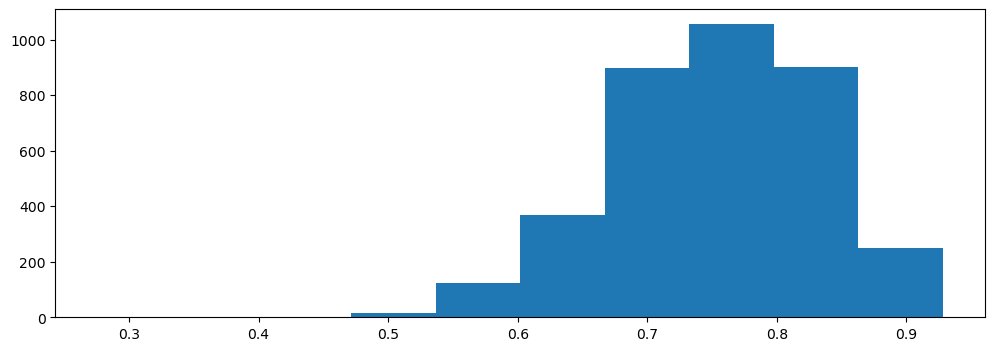

In [158]:
plt.hist(hrv_train_clean['Mean_Quality']); #You can base number below on this perhaps

In [192]:
hrv_train_clean = hrv_train_clean.loc[hrv_train_clean['Mean_Quality'] >= 0] #You can adjust this number to be higher or lower

## Outlier Detection

In [193]:
# Function to identify outliers in the data
def identify_outliers(df, column_name, threshold=1.5):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify outliers
    row_indices = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index.tolist()
    outlier_values = df.loc[row_indices, column_name].tolist()

    return row_indices, outlier_values, lower_bound, upper_bound

In [194]:
# Outlier detection ONLY ON TRAIN

# Merge labels with TRAIN features (cleaned hrv_train)
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on="ecg_index", right_index=True
)

# Outlier detection ONLY on TRAIN
train_outlier_idx, outlier_values, iqr_lower, iqr_upper = identify_outliers(
    hrv_train_with_labels,
    "HRV_MedianNN",
    threshold=1.5
)

# ecg_index as (int)
hrv_train_with_labels["ecg_index"] = hrv_train_with_labels["ecg_index"].astype(int)

print("Train outliers detected:", len(train_outlier_idx))
print("Row indices (in hrv_train_with_labels) with outliers:", train_outlier_idx)
print("Outlier HRV_MedianNN values:", outlier_values)

Train outliers detected: 49
Row indices (in hrv_train_with_labels) with outliers: [44, 256, 358, 446, 447, 519, 522, 554, 557, 581, 661, 773, 870, 878, 926, 1059, 1278, 1516, 1945, 1991, 2027, 2070, 2145, 2285, 2297, 2305, 2579, 2613, 2646, 2688, 2803, 2806, 2865, 2955, 2995, 2997, 3011, 3018, 3025, 3119, 3128, 3148, 3186, 3287, 3322, 3422, 3467, 3470, 3614]
Outlier HRV_MedianNN values: [398.33333333333337, 426.66666666666663, 398.33333333333337, 1310.0, 425.0, 410.0, 380.0, 405.0, 386.6666666666667, 396.6666666666667, 396.6666666666667, 350.0, 326.6666666666667, 376.66666666666663, 360.0, 403.33333333333337, 1300.0, 385.0, 426.6666666666667, 2323.333333333333, 396.6666666666667, 2050.0, 390.0, 426.6666666666667, 396.6666666666667, 361.66666666666663, 396.6666666666667, 2116.6666666666665, 400.0, 390.0, 393.3333333333333, 413.3333333333333, 393.3333333333333, 420.0, 418.33333333333337, 376.66666666666663, 1360.0, 1280.0, 376.66666666666663, 423.3333333333333, 2003.3333333333333, 423.33

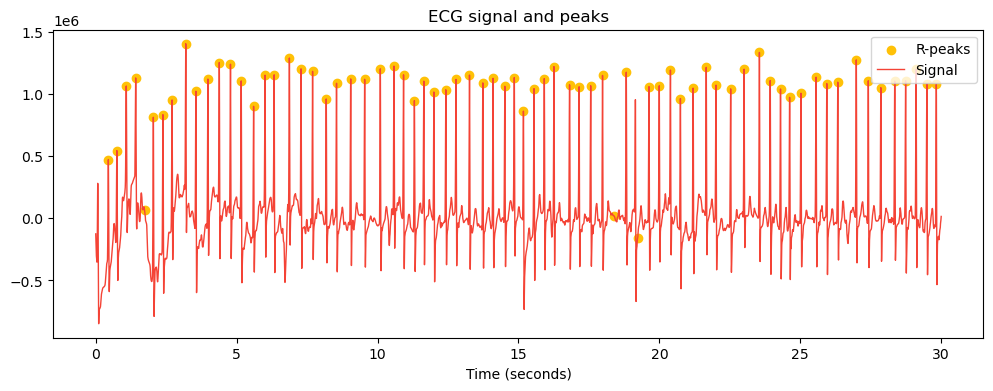

In [195]:
# Visualise one outlier ECG

example_outlier_row = train_outlier_idx[0]

# Single row
row = hrv_train_with_labels.loc[example_outlier_row]

# Extract ECG index value
ecg_index_values = row.filter(like="ecg_index").values

# Use first value
ecg_idx = int(ecg_index_values[0])

# Extract raw ECG from df
ecg_raw = df.iloc[ecg_idx].astype(float).values

# Visualise R-Peaks
peaks_outlier, info_outlier = nk.ecg_peaks(
    ecg_raw,
    sampling_rate=sampling_frequency,
    correct_artifacts=True,
    show=True
)

In [196]:
hrv_train_with_labels.loc[example_outlier_row]

HRV_MeanNN                       407.962963
HRV_SDNN                          72.335411
HRV_RMSSD                         94.653639
HRV_SDSD                          95.326167
HRV_CVNN                           0.177309
                               ...         
Mean_Quality                       0.823365
Mean_PWave_Amplitude           13279.772029
STDEV_Pwave                         0.20146
label                   Atrial Fibrillation
classification                            1
Name: 44, Length: 77, dtype: object

#### **Outliers TEST set** done the same way as for TRAINING

In [197]:
# Align TEST columns to TRAIN columns

# Align TEST columns to TRAIN columns (no leakage, same feature space)
train_cols = hrv_train_clean.columns  # already cleaned on TRAIN
shared_cols = [c for c in train_cols if c in hrv_test_clean.columns]

hrv_test_aligned = hrv_test_clean[shared_cols].copy()

# Merge TEST HRV with labels
hrv_test_with_labels = pd.merge(
    hrv_test_aligned,
    df_labels[["label", "classification"]],
    left_on="ecg_index",
    right_index=True
)

In [198]:
# Same IQR bounds as on hrv_train

Q1 = hrv_train_clean["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_clean["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

hrv_test_clean = hrv_test_with_labels[
    (hrv_test_with_labels["HRV_MedianNN"] >= lower_bound) &
    (hrv_test_with_labels["HRV_MedianNN"] <= upper_bound)
    ].copy()

print("hrv_test shape:", hrv_test_clean.shape)
print("hrv_test_with_labels shape:", hrv_test_with_labels.shape)
print("hrv_test_clean shape:", hrv_test_clean.shape)

hrv_test shape: (892, 76)
hrv_test_with_labels shape: (892, 76)
hrv_test_clean shape: (892, 76)


## Distribution TRAIN + TEST | Sanity check

In [199]:
print(hrv_train_clean.columns[:5])
print(hrv_test_clean.columns[:5])
print(hrv_test_clean[["HRV_MedianNN", "classification"]].head())

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN'], dtype='object')
Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN'], dtype='object')
   HRV_MedianNN  classification
0   1190.000000               0
1    451.666667               1
2   1083.333333               0
3    505.000000               1
4    811.666667               0


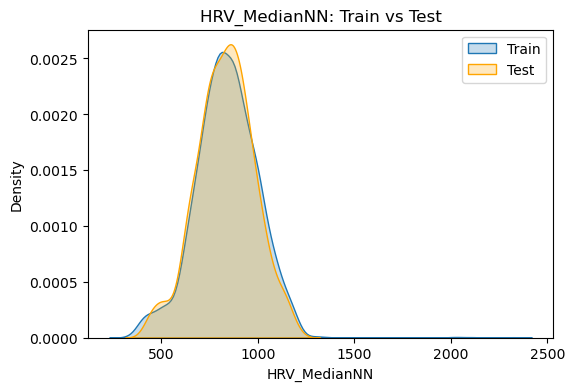

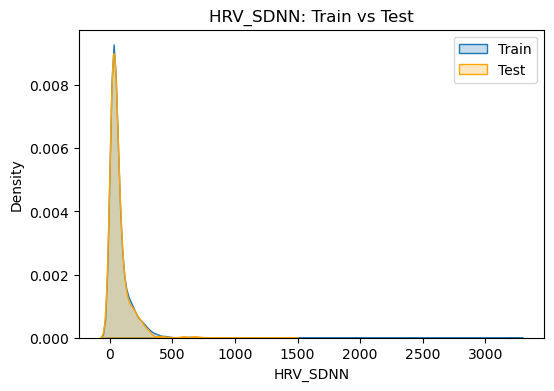

In [200]:
for feat in ["HRV_MedianNN", "HRV_SDNN"]:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        data=hrv_train_clean, x=feat, label="Train", fill=True, common_norm=False
    )
    sns.kdeplot(
        data=hrv_test_clean, x=feat, label="Test", fill=True, common_norm=False, color="orange"
    )
    plt.title(f"{feat}: Train vs Test")
    plt.legend()
    plt.show()

### Outlier Handling TRAIN

#### Winsorising outliers

In [201]:
Q1 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_clip = Q1 - 1.5 * IQR
upper_clip = Q3 + 1.5 * IQR

hrv_train_winsor = hrv_train_with_labels.copy()
hrv_train_winsor["HRV_MedianNN_winsor"] = hrv_train_with_labels["HRV_MedianNN"].clip(
    lower=lower_clip, upper=upper_clip
)

print("Shape after winsorizing (same as original):", hrv_train_winsor.shape)

Shape after winsorizing (same as original): (3487, 78)


### Outlier Handling Comparison

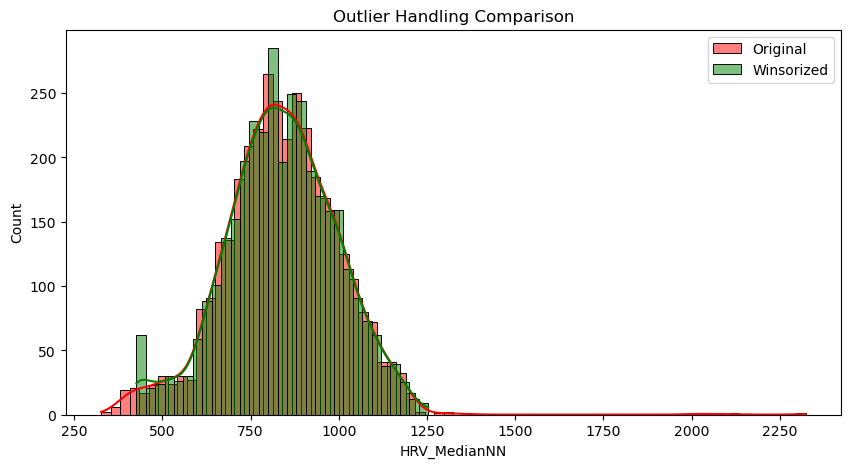

In [202]:
plt.figure(figsize=(10, 5))
sns.histplot(hrv_train_with_labels["HRV_MedianNN"], kde=True, color="red", label="Original")
sns.histplot(hrv_train_winsor["HRV_MedianNN_winsor"], kde=True, color="green", label="Winsorized")

plt.legend()
plt.title("Outlier Handling Comparison")
plt.show()

# Final Preprocessing: Building ML Matrices (X_train, X_test)

In [203]:
# Select HRV feature columns only
feature_cols = [col for col in hrv_train_with_labels.columns if col.startswith("HRV_")]

# TRAIN data
x_train = hrv_train_with_labels[feature_cols].copy()
y_train = hrv_train_with_labels["classification"].copy()

# TEST data
x_test = hrv_test_clean[feature_cols].copy()
y_test = hrv_test_clean["classification"].copy()

In [204]:
# Replace +/- inf with NaN in both TRAIN and TEST
for df_ in (x_train, x_test):
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns that are all-NaN (if any)
all_nan_cols = x_train.columns[x_train.isna().all()]
if len(all_nan_cols) > 0:
    print("Dropping all-NaN columns before imputation:", list(all_nan_cols))
    x_train.drop(columns=all_nan_cols, inplace=True)
    x_test.drop(columns=all_nan_cols, inplace=True)

## Imputation

In [205]:
# Median imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# X_train: fit_transform
X_train_imputed = imputer.fit_transform(x_train)

# X_test: only transform (so test set remains untouched)
X_test_imputed = imputer.transform(x_test)

## Normalisation

In [206]:
#Temporarily convert to DataFrame to calculate Skewness easily
temp_df = pd.DataFrame(X_train_imputed, columns=feature_cols)
skewness = temp_df.skew().sort_values(ascending=False)

#Identify skewed columns (Threshold > 1.0)
skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()

#Apply Log Transform directly to the NumPy arrays
for col_name in skewed_cols:
    # Find the column index (integer position)
    col_idx = feature_cols.index(col_name)

    # Check for negative values (Log crashes on negatives)
    # We find the global minimum for this column across Train and Test
    min_val = min(X_train_imputed[:, col_idx].min(), X_test_imputed[:, col_idx].min())

    shift = 0
    if min_val < 0:
        # If negatives exist, calculate a shift to make the minimum 0
        shift = abs(min_val)

    # Apply transformation in-place: Log(x + shift + 1)
    X_train_imputed[:, col_idx] = np.log1p(X_train_imputed[:, col_idx] + shift)
    X_test_imputed[:, col_idx] = np.log1p(X_test_imputed[:, col_idx] + shift)

## Scaling

In [207]:
scaler = RobustScaler()

# X_train: fit_transform
X_train_scaled = scaler.fit_transform(X_train_imputed)

# X_test: only transform (so test set remains untouched)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert back to df with column names
x_train = pd.DataFrame(X_train_scaled, columns=feature_cols)
x_test = pd.DataFrame(X_test_scaled, columns=feature_cols)

### **Sanity checks**

In [208]:
# Median X_train
print("Median of scaled features (should be ~0):")
print(x_train.median().round(3))

# IQR X_train
print("\nIQR of scaled features (should be ~1):")
print((x_train.quantile(0.75) - x_train.quantile(0.25)).round(3))

#Checking skewness of the datasets
skewness_train = x_train.skew().sort_values(ascending=False)
skewness_test = x_train.skew().sort_values(ascending=False)
# Filter for highly skewed columns (absolute skew > 1.0)
high_skew_cols_train = skewness_train[abs(skewness_train) > 1.0]
high_skew_cols_test = skewness_test[abs(skewness_test) > 1.0]

print(len(high_skew_cols_train))
print(len(high_skew_cols_test))

Median of scaled features (should be ~0):
HRV_MeanNN    0.0
HRV_SDNN      0.0
HRV_RMSSD     0.0
HRV_SDSD      0.0
HRV_CVNN      0.0
             ... 
HRV_RCMSEn    0.0
HRV_CD        0.0
HRV_HFD       0.0
HRV_KFD       0.0
HRV_LZC       0.0
Length: 71, dtype: float64

IQR of scaled features (should be ~1):
HRV_MeanNN    1.0
HRV_SDNN      1.0
HRV_RMSSD     1.0
HRV_SDSD      1.0
HRV_CVNN      1.0
             ... 
HRV_RCMSEn    1.0
HRV_CD        1.0
HRV_HFD       1.0
HRV_KFD       1.0
HRV_LZC       1.0
Length: 71, dtype: float64
15
15


# Final ML datasets (X_train, X_test, y_train, y_test

In [209]:
print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

Train size: 3619
Test size: 905


In [210]:
if True:
    # Feature matrices (winsorised > imputation > scaling)
    x_train = X_train_scaled
    x_test = X_test_scaled

    # Target vectors (created earlier from HRV + labels AF(0/1))
    y_train = hrv_train_with_labels["classification"].copy()
    y_test = hrv_test_clean["classification"].copy()

    print("Final X_train shape:", x_train.shape)
    print("Final X_test shape:", x_test.shape)
    print("Final y_train shape:", y_train.shape)
    print("Final y_test shape:", y_test.shape)

Final X_train shape: (3487, 71)
Final X_test shape: (892, 71)
Final y_train shape: (3487,)
Final y_test shape: (892,)


# Machine Learning Training Setup

## Safety check

In [211]:
assert len(x_train) == len(y_train), "Misaligned TRAIN matrix and labels!"
assert len(x_test) == len(y_test), "Misaligned TEST matrix and labels!"

assert not np.isnan(x_train).any(), "NaNs detected in X_train!"
assert not np.isnan(x_test).any(), "NaNs detected in X_test!"

## Comparison framework

In [212]:
resultsTable = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC', 'ROC_AUC', 'cm'])

def modelResults(model, accuracy, f1, precision, recall, roc_auc, roc_cur, cm):
    print(
        f"Model {model} evaluated. \nAccuracy: {accuracy} \nF1 Score: {f1} \nPrecision: {precision} \nRecall: {recall} \nROC AUC: {roc_auc}")
    resultsTable.loc[len(resultsTable)] = [model, accuracy, f1, precision, recall, roc_cur, roc_auc, cm]
    resultsTable.to_csv("data/trainingResults.csv", index=False, mode="a")

In [213]:
print(
    f"X train length: {len(x_train)}\n X test length: {len(x_test)} \n Y train length: {len(y_train)}\n Y test length: {len(y_test)}")

X train length: 3487
 X test length: 892 
 Y train length: 3487
 Y test length: 892


In [214]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

#Going back to basics, the currently used x_train and x_test gave ValueErrors as negative values for Log

raw_cols = [c for c in hrv_train_with_labels.columns if c.startswith("HRV_")]
raw_train = hrv_train_with_labels[raw_cols].copy()
raw_test = hrv_test_clean[raw_cols].copy()

raw_train.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_test.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer_eng = SimpleImputer(strategy="median")
raw_train_imp = pd.DataFrame(imputer_eng.fit_transform(raw_train), columns=raw_cols)
raw_test_imp = pd.DataFrame(imputer_eng.transform(raw_test), columns=raw_cols)

skewness = raw_train_imp.skew().sort_values(ascending=False)
skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()

new_features_train = pd.DataFrame(index=raw_train_imp.index)
new_features_test = pd.DataFrame(index=raw_test_imp.index)

#1. Log Transforms
for col in skewed_cols:
    # +1e-6 avoids log(0)
    new_features_train[f'Log_{col}'] = np.log(raw_train_imp[col] + 1e-6)
    new_features_test[f'Log_{col}'] = np.log(raw_test_imp[col] + 1e-6)

#2. 2. Coefficient of Variation (CV) computation:
if 'HRV_SDNN' in raw_train_imp.columns and 'HRV_MeanNN' in raw_train_imp.columns:
    new_features_train['CV_SDNN'] = raw_train_imp['HRV_SDNN'] / (raw_train_imp['HRV_MeanNN'] + 1e-6)
    new_features_test['CV_SDNN'] = raw_test_imp['HRV_SDNN'] / (raw_test_imp['HRV_MeanNN'] + 1e-6)

# 3. Chaos Index (Amplifies the "irregularly irregular" signal specific to AF.):
entropy_col = 'HRV_ApEn' if 'HRV_ApEn' in raw_train_imp.columns else 'HRV_SampEn'
if 'HRV_RMSSD' in raw_train_imp.columns and entropy_col in raw_train_imp.columns:
    new_features_train['Chaos_Index'] = raw_train_imp['HRV_RMSSD'] * raw_train_imp[entropy_col]
    new_features_test['Chaos_Index'] = raw_test_imp['HRV_RMSSD'] * raw_test_imp[entropy_col]

new_features_train.replace([np.inf, -np.inf], np.nan, inplace=True)
new_features_test.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer_new = SimpleImputer(strategy="median")
new_train_clean = pd.DataFrame(imputer_new.fit_transform(new_features_train), columns=new_features_train.columns)
new_test_clean = pd.DataFrame(imputer_new.transform(new_features_test), columns=new_features_test.columns)

scaler_eng = RobustScaler()
new_train_scaled = pd.DataFrame(scaler_eng.fit_transform(new_train_clean), columns=new_features_train.columns)
new_test_scaled = pd.DataFrame(scaler_eng.transform(new_test_clean), columns=new_features_test.columns)

if not isinstance(x_train, pd.DataFrame):
    x_train = pd.DataFrame(x_train, columns=feature_cols)
if not isinstance(x_test, pd.DataFrame):
    x_test = pd.DataFrame(x_test, columns=feature_cols)

x_train_added = pd.concat([x_train, new_train_scaled], axis=1)
x_test_added = pd.concat([x_test, new_test_scaled], axis=1)

# Machine Learning Training

## Soft voting classifier

Model VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 multi_class='auto',
                                                 random_state=3003)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='log_loss',
                                                     n_estimators=500,
                                                     random_state=3003)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=8,
                                                   weights='distance')),
                             ('ada',
                              AdaBoostClassifier(n_estimators=1500,
                                                 random_state=3003

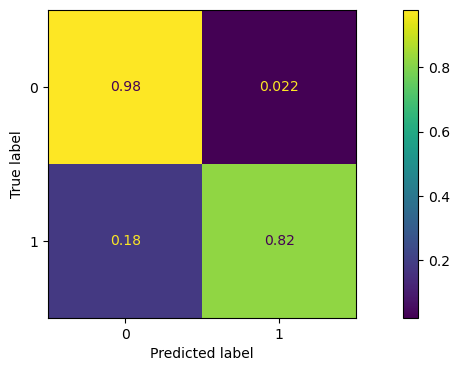

In [232]:
voters = [
    ("lr", LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced', random_state=3003)),
    ("rf", RandomForestClassifier(n_estimators=500, random_state=3003, class_weight='balanced', criterion="log_loss")),
    ("knn", KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto', p=2)),
    ("ada", AdaBoostClassifier(n_estimators=1500, random_state=3003))
]

soft_vote = VotingClassifier(estimators=voters, voting="soft", n_jobs=-1)
soft_vote.fit(x_train, y_train)

y_pred_proba = soft_vote.predict_proba(x_test)[:, 1]
y_pred = soft_vote.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_cur = roc_curve(y_test, y_pred_proba)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')
modelResults(soft_vote, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=soft_vote.classes_)
disp.plot()

# Model evaluation

In [228]:
resultsTable

,Model,Accuracy,F1 Score,Precision,Recall,ROC,ROC_AUC,cm
0,"VotingClassifier(estimators=[('lr',\n ...",0.959641,0.828571,0.836538,0.820755,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.983221,"[[0.9783715012722646, 0.021628498727735368], [..."
1,"VotingClassifier(estimators=[('lr',\n ...",0.959641,0.828571,0.836538,0.820755,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.983401,"[[0.9783715012722646, 0.021628498727735368], [..."
2,"VotingClassifier(estimators=[('lr',\n ...",0.957399,0.819048,0.826923,0.811321,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.983569,"[[0.9770992366412213, 0.022900763358778626], [..."
3,"VotingClassifier(estimators=[('lr',\n ...",0.958520,0.822967,0.834951,0.811321,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.983209,"[[0.9783715012722646, 0.021628498727735368], [..."
4,"VotingClassifier(estimators=[('lr',\n ...",0.959641,0.828571,0.836538,0.820755,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.983221,"[[0.9783715012722646, 0.021628498727735368], [..."
5,"VotingClassifier(estimators=[('lr',\n ...",0.956278,0.816901,0.813084,0.820755,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.983905,"[[0.9745547073791349, 0.02544529262086514], [0..."
6,"VotingClassifier(estimators=[('lr',\n ...",0.957399,0.817308,0.833333,0.801887,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.983341,"[[0.9783715012722646, 0.021628498727735368], [..."
7,"VotingClassifier(estimators=[('lr',\n ...",0.959641,0.828571,0.836538,0.820755,"([0.0, 0.0, 0.0, 0.002544529262086514, 0.00254...",0.983365,"[[0.9783715012722646, 0.021628498727735368], [..."
8,"VotingClassifier(estimators=[('lr',\n ...",0.958520,0.824645,0.828571,0.820755,"([0.0, 0.0, 0.0, 0.001272264631043257, 0.00127...",0.982464,"[[0.9770992366412213, 0.022900763358778626], [..."


## ROC Curves

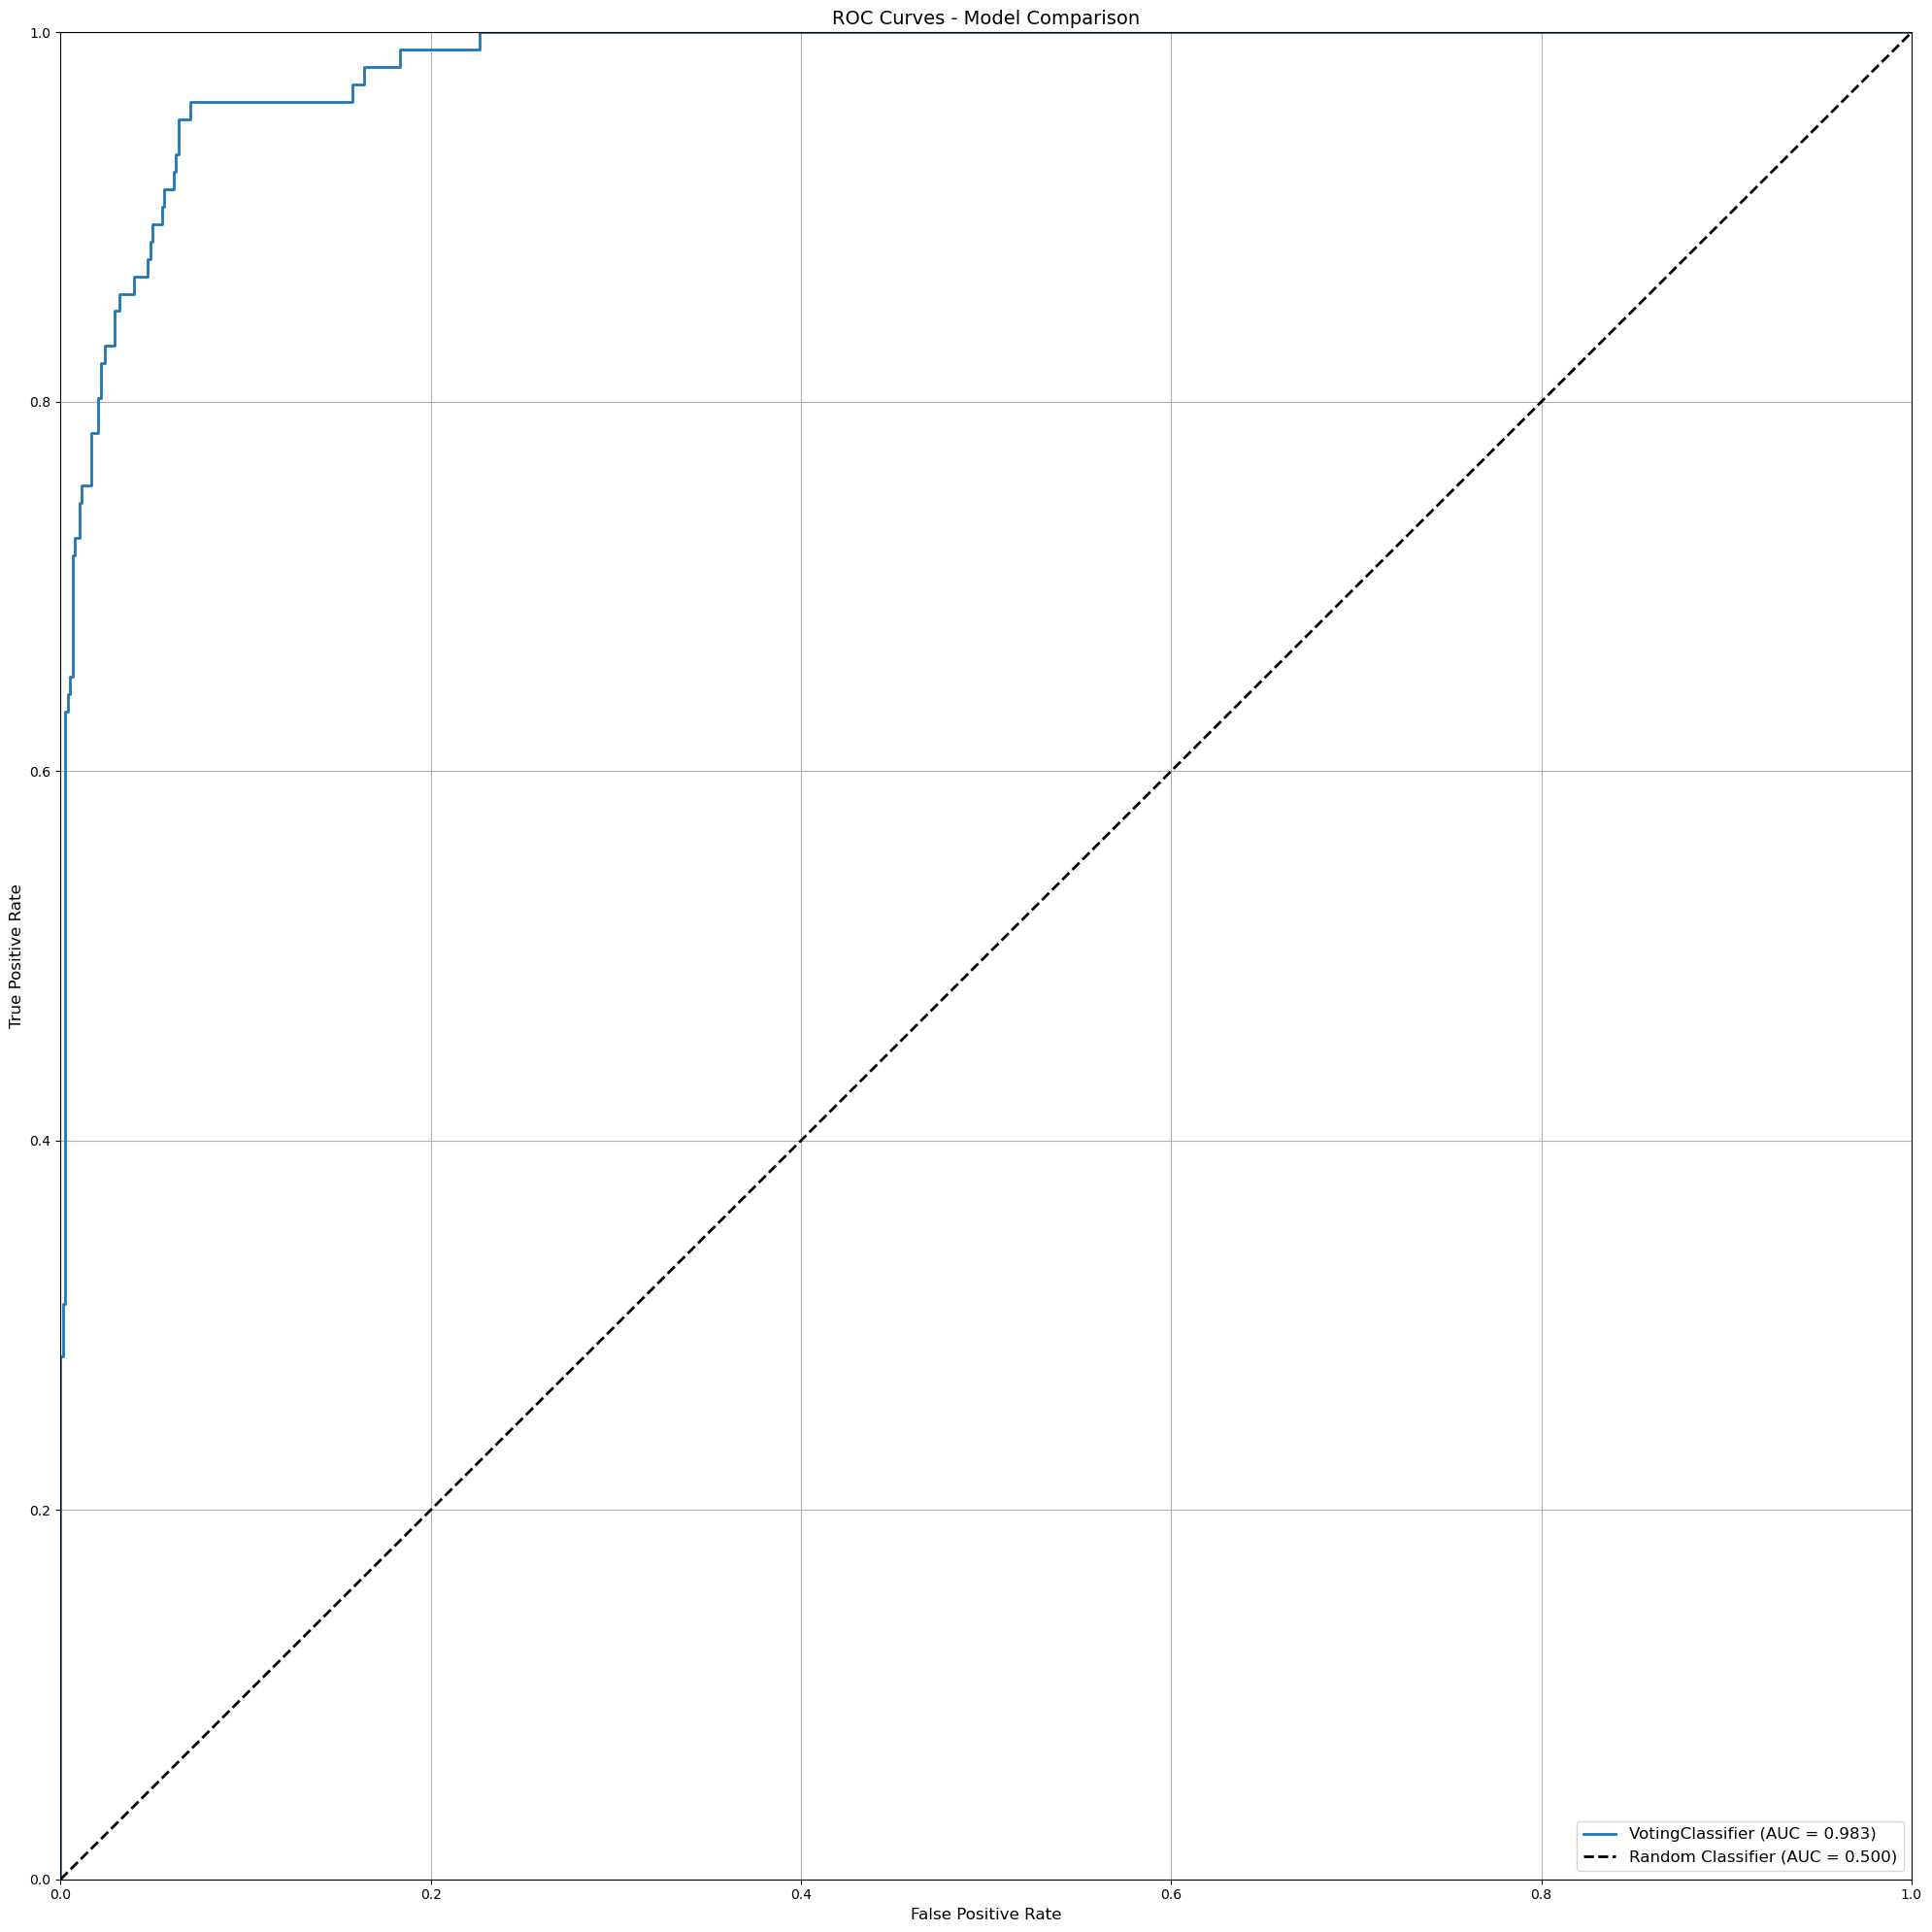

In [217]:
plt.figure(figsize=(20, 20))

for idx, row in resultsTable.iterrows():
    model_name = str(row['Model']).split('(')[0]
    fpr, tpr, thresholds = row['ROC']
    roc_auc = row['ROC_AUC']
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=1)
plt.tight_layout()
plt.show()